In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds

In [22]:
# tfds.load returns a tf.data.Dataset object and a tf.core.DatasetInfo object. The latter contains info about how the set is split 
# into test and train, number of examples and names of features
dataset, metadata = tfds.load('mnist', as_supervised=True, with_info=True) 
train_dataset, test_dataset = dataset['train'], dataset['test']

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

In [23]:
# Size of training and test sets
train_size = metadata.splits['train'].num_examples
test_size = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(train_size))
print("Number of test examples:     {}".format(test_size))
# Normalise data
def minmaxScaling(images, labels):
    images = tf.cast(images, tf.float32)
    images = images/255
    return images, labels

train_dataset = train_dataset.map(minmaxScaling)
test_dataset = test_dataset.map(minmaxScaling)

Number of training examples: 60000
Number of test examples:     10000


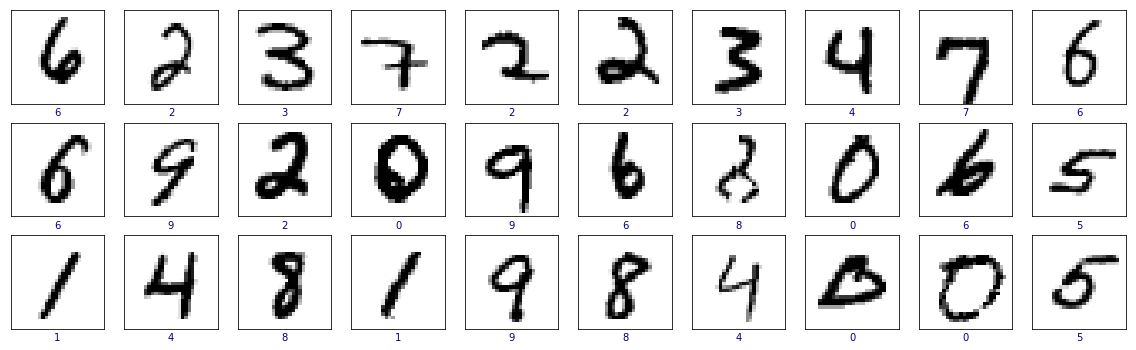

In [24]:
# Print example 
plt.figure(figsize=(20,10))
i = 0
for (image, label) in test_dataset.take(30):
    image = image.numpy().reshape(28,28)
    plt.subplot(5,10,i+1)
    plt.imshow(image, cmap= plt.cm.binary)
    plt.xlabel(label.numpy(), color='navy')
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.show()

In [25]:
# Shuffling and batching of training set 
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(train_size).batch(BATCH_SIZE)
test_dataset_batched = test_dataset.batch(BATCH_SIZE)

## Dense model

In [26]:
# Dense model setup
# One dense layer with 128 neurons, output layer with 10 neurons. 
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, input_shape=([784]), activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
# Compile model
dense.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'adam',
              metrics=['accuracy'])

In [27]:
# Training model
dense.fit(train_dataset, epochs=5, verbose=True, steps_per_epoch=np.ceil(train_size/BATCH_SIZE))

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1875/1875 [==============================] - 40s 21ms/step - loss: 0.2563 - accuracy: 0.8792
Epoch 2/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1140 - accuracy: 0.9623
Epoch 3/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0751 - accuracy: 0.9751
Epoch 4/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.0542 - accuracy: 0.9816
Epoch 5/5
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0462 - accuracy: 0.9848


In [28]:
# Evaluation and predictions
test_loss, test_acc = dense.evaluate(test_dataset_batched, steps=np.ceil(test_size/BATCH_SIZE))
dense_predictions = dense.predict(test_dataset_batched)

313/313 [==============================] - 4s 12ms/step - loss: 0.0699 - accuracy: 0.9790


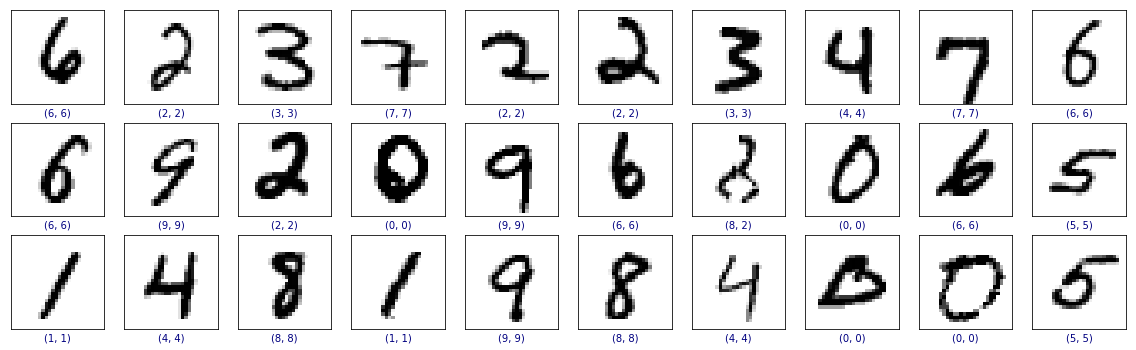

In [29]:
# Print example and its predicted class
plt.figure(figsize=(20,10))
i = 0
for (image, label) in test_dataset.take(30):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,10,i+1)
    plt.imshow(image, cmap= plt.cm.binary)
    plt.xlabel((label.numpy(), dense_predictions[i].argmax()), color='navy')#
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.show()

## Convolutional model

In [31]:
# Convolutional model setup
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                          input_shape=(28,28,1), data_format='channels_last', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',
                          data_format='channels_last', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, input_shape=([784]), activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])
# Compile model
cnn.compile(loss='sparse_categorical_crossentropy', 
              optimizer = 'adam',
              metrics=['accuracy'])

In [32]:
# Training model
cnn.fit(train_dataset, epochs=5, verbose=True, steps_per_epoch=np.ceil(train_size/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 147s 79ms/step - loss: 0.2189 - accuracy: 0.9310
Epoch 2/5
1875/1875 [==============================] - 147s 78ms/step - loss: 0.0861 - accuracy: 0.9738
Epoch 3/5
1875/1875 [==============================] - 152s 81ms/step - loss: 0.0650 - accuracy: 0.9792
Epoch 4/5
1875/1875 [==============================] - 167s 89ms/step - loss: 0.0548 - accuracy: 0.9825
Epoch 5/5
1875/1875 [==============================] - 173s 92ms/step - loss: 0.0482 - accuracy: 0.9846


In [33]:
# Evaluation and predictions
test_loss, test_acc = cnn.evaluate(test_dataset_batched, steps=np.ceil(test_size/BATCH_SIZE))
cnn_predictions = cnn.predict(test_dataset_batched)

313/313 [==============================] - 9s 29ms/step - loss: 0.0309 - accuracy: 0.9898


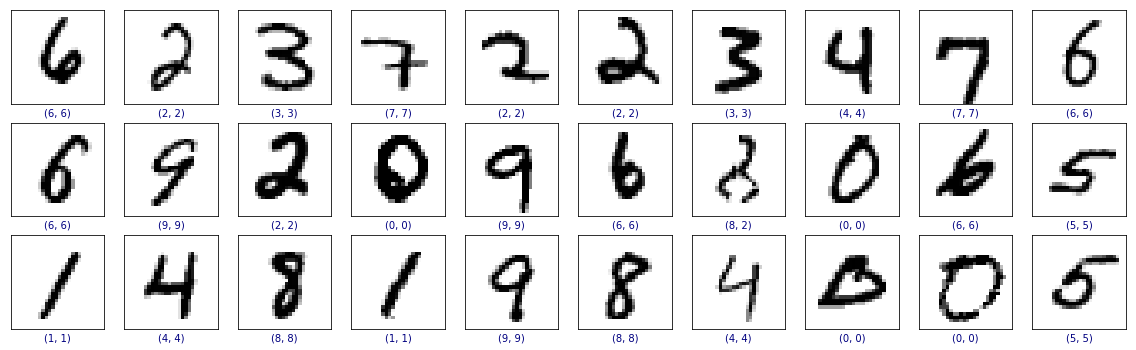

In [34]:
# Print example and its predicted class
plt.figure(figsize=(20,10))
i = 0
for (image, label) in test_dataset.take(30):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,10,i+1)
    plt.imshow(image, cmap= plt.cm.binary)
    plt.xlabel((label.numpy(), cnn_predictions[i].argmax()), color='navy')#
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.show()